# Income Range, US Census 1994

Data from: https://archive.ics.uci.edu/ml/datasets/Adult

Task is to classify income into two groups: less than or equal to 50k/year, or more than 50k/year

In [1]:
%matplotlib inline

import collections

import pandas as pd
import numpy as np
import sklearn
from ggplot import *
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plot_interactive_tree(model, feature_names, class_names=None):
    from IPython.display import Image  
    from sklearn import tree
    import pydotplus 
    dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=feature_names,
                         class_names=class_names,
                         filled=True, rounded=True,  
                         special_characters=True)  

    graph = pydotplus.graph_from_dot_data(dot_data.decode('ascii').encode('utf8'))  

    return Image(graph.create_png()) 

## Pre-processing


Following steps were taken:
  - Strings were stripped (to remove spaces)
  - All categorical features were one-hot-encoded into independent features
  - Output variable was converted to a binary feature
  

In [3]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'native-country']

def read_data(kind='train'):
    '''
    >50K, <=50K.

    age: continuous.
    workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    fnlwgt: continuous.
    education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    education-num: continuous.
    marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
    occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
    relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    sex: Female, Male.
    capital-gain: continuous.
    capital-loss: continuous.
    hours-per-week: continuous.
    native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.    
    '''
    
    filename = '.data/adult.data' if kind == 'train' else '.data/adult.test'
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'y']
    
    df = pd.read_csv(filename, header=None)
    df.columns = columns
    
    for c in categorical_features:
        df[c] = df[c].map(lambda x: x.strip())
    
    df.replace('?', 'Unknown', inplace=True)
    df['y'] = df['y'].map(lambda x: x.strip()).map(lambda x: '<=50K' if '<=50K' in x else x).map(lambda x: '>50K' if '>50K' in x else x)
    df['y'] = df['y'].map(lambda x: 0 if x == '<=50K' else 1)
    
    for c in categorical_features:
        df[c] = df[c].astype("category")
    return df


def categorial_transform(data_frames):
    category_values = collections.defaultdict(set)
    
    for c in categorical_features:
        values = []
        for df in data_frames:

            values.extend(df[c].unique())
        
        category_values[c] = set(values)
        
    for k,v in category_values.items():
        print k, '==>', v, '\n'
        
    for c in categorical_features:
        for v in category_values[c]:
            cname = '%s_%s' % (c, v)
            for df in data_frames:
                df[cname] = df[c].map(lambda x: 1 if x == v else 0)
    
    for df in data_frames:
        df.drop(categorical_features, axis=1, inplace=True)
    
def ml_split(df):
    
    X = df.drop(['y'], axis=1)
    y = df['y']
    
    return X, y

In [4]:
train = read_data('train')
test = read_data('test')

categorial_transform([train, test])

train.head(5)


workclass ==> set(['Self-emp-inc', 'State-gov', 'Without-pay', 'Never-worked', 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'Unknown']) 

relationship ==> set(['Own-child', 'Wife', 'Unmarried', 'Other-relative', 'Husband', 'Not-in-family']) 

sex ==> set(['Male', 'Female']) 

race ==> set(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'White', 'Other', 'Black']) 

native-country ==> set(['Canada', 'Hong', 'Dominican-Republic', 'Italy', 'Ireland', 'Unknown', 'Scotland', 'Cambodia', 'France', 'Peru', 'Laos', 'Ecuador', 'Iran', 'Cuba', 'Guatemala', 'Germany', 'Thailand', 'Haiti', 'Poland', 'Holand-Netherlands', 'Philippines', 'Outlying-US(Guam-USVI-etc)', 'Vietnam', 'Hungary', 'England', 'South', 'Jamaica', 'Honduras', 'Portugal', 'Mexico', 'El-Salvador', 'India', 'Puerto-Rico', 'China', 'Yugoslavia', 'United-States', 'Trinadad&Tobago', 'Greece', 'Japan', 'Taiwan', 'Nicaragua', 'Columbia']) 

education ==> set(['Masters', 'Prof-school', '12th', 'Assoc-voc', '1st-4th', 'Assoc-a

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,y,workclass_Self-emp-inc,workclass_State-gov,workclass_Without-pay,...,native-country_Puerto-Rico,native-country_China,native-country_Yugoslavia,native-country_United-States,native-country_Trinadad&Tobago,native-country_Greece,native-country_Japan,native-country_Taiwan,native-country_Nicaragua,native-country_Columbia
0,39,77516,13,2174,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classification

Made use of random forest classifier

In [5]:
Xtrain, ytrain = ml_split(train)
Xtest, ytest = ml_split(test)

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=6, min_samples_split=5, 
                             bootstrap=True, min_samples_leaf=5, n_jobs=1)
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [7]:
accuracy = clf.score(Xtrain, ytrain)
print 'Accuracy: {:.3f}'.format(accuracy)

Accuracy: 0.845


Testing AUC: 0.903
             precision    recall  f1-score   support

          0       0.85      0.96      0.90     12435
          1       0.80      0.46      0.58      3846

avg / total       0.84      0.84      0.83     16281



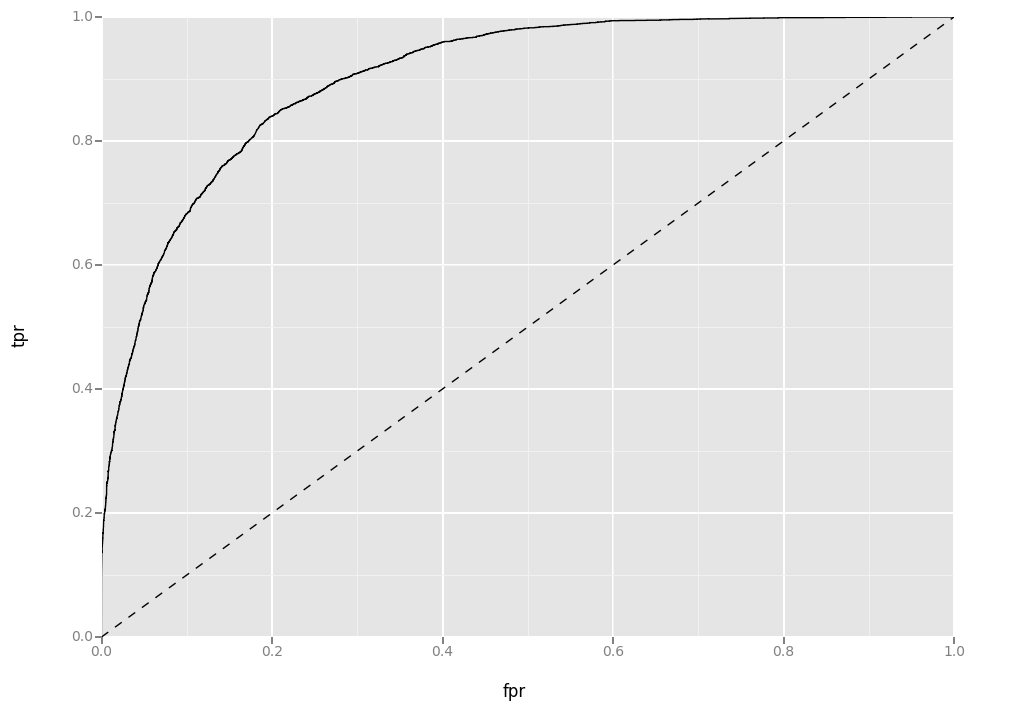

<ggplot: (279458709)>

In [8]:
from sklearn import metrics

preds = clf.predict_proba(Xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest, preds)

print 'Testing AUC: {:.3f}'.format(metrics.roc_auc_score(ytest, preds))

print metrics.classification_report(ytest, [round(x) for x in preds])

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

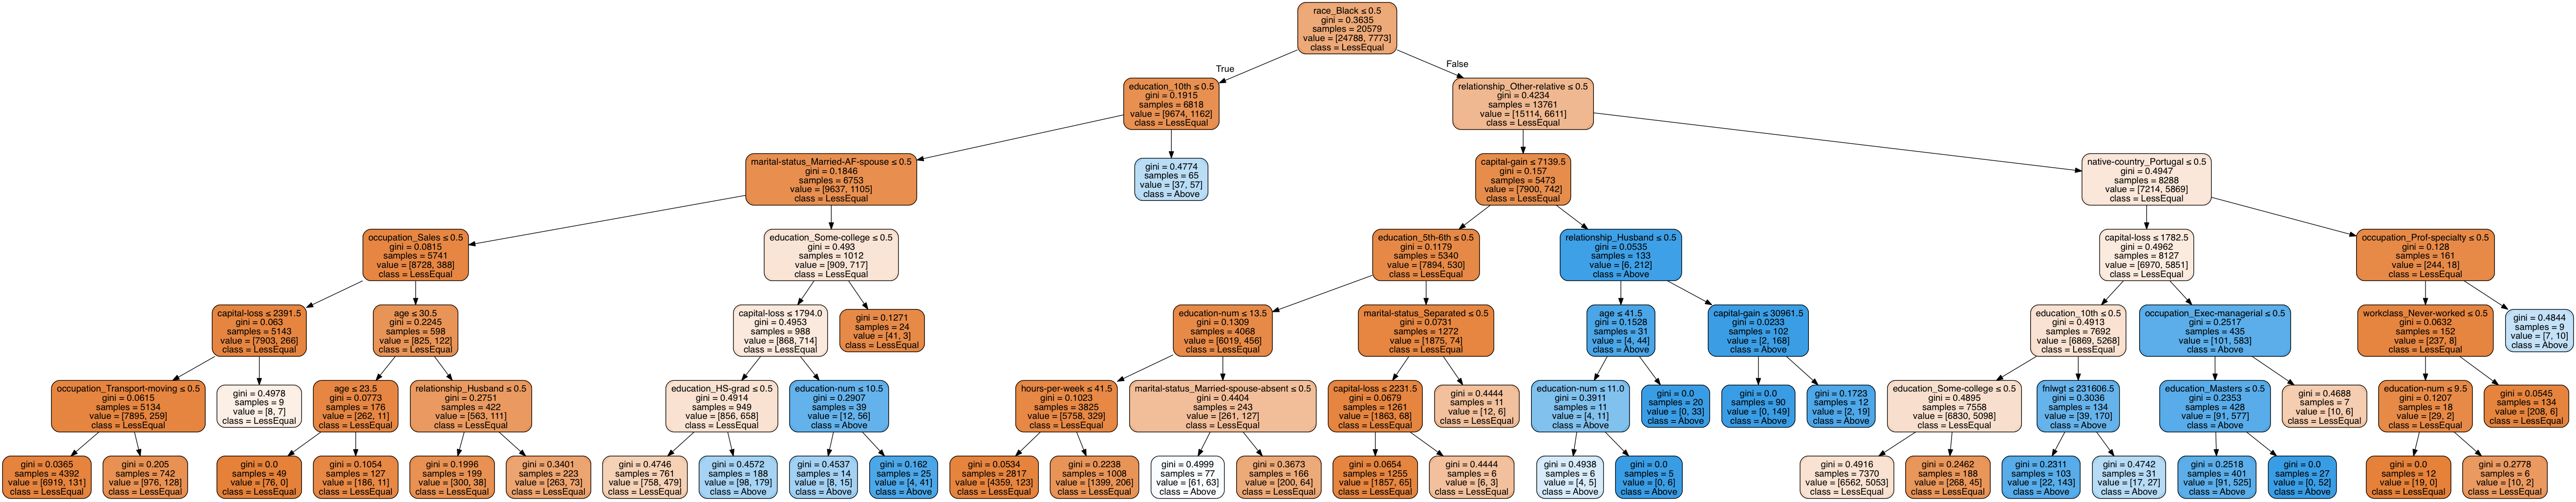

In [9]:
plot_interactive_tree(clf.estimators_[0], train.columns[:-1], class_names=['LessEqual', 'Above'])

In [10]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
 
for f in range(Xtrain.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, Xtrain.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature marital-status_Married-civ-spouse (0.161728)
2. feature capital-gain (0.143705)
3. feature relationship_Husband (0.123960)
4. feature education-num (0.103447)
5. feature marital-status_Never-married (0.070613)
6. feature age (0.059123)
7. feature hours-per-week (0.038380)
8. feature occupation_Exec-managerial (0.028676)
9. feature capital-loss (0.026829)
10. feature occupation_Prof-specialty (0.024852)
11. feature relationship_Own-child (0.024460)
12. feature sex_Female (0.023059)
13. feature education_Bachelors (0.021634)
14. feature relationship_Not-in-family (0.021414)
15. feature relationship_Wife (0.018220)
16. feature sex_Male (0.017360)
17. feature education_Masters (0.013920)
18. feature marital-status_Divorced (0.009738)
19. feature education_HS-grad (0.009070)
20. feature occupation_Other-service (0.008638)
21. feature relationship_Unmarried (0.008280)
22. feature education_Prof-school (0.008187)
23. feature education_Doctorate (0.005392)
24. featu

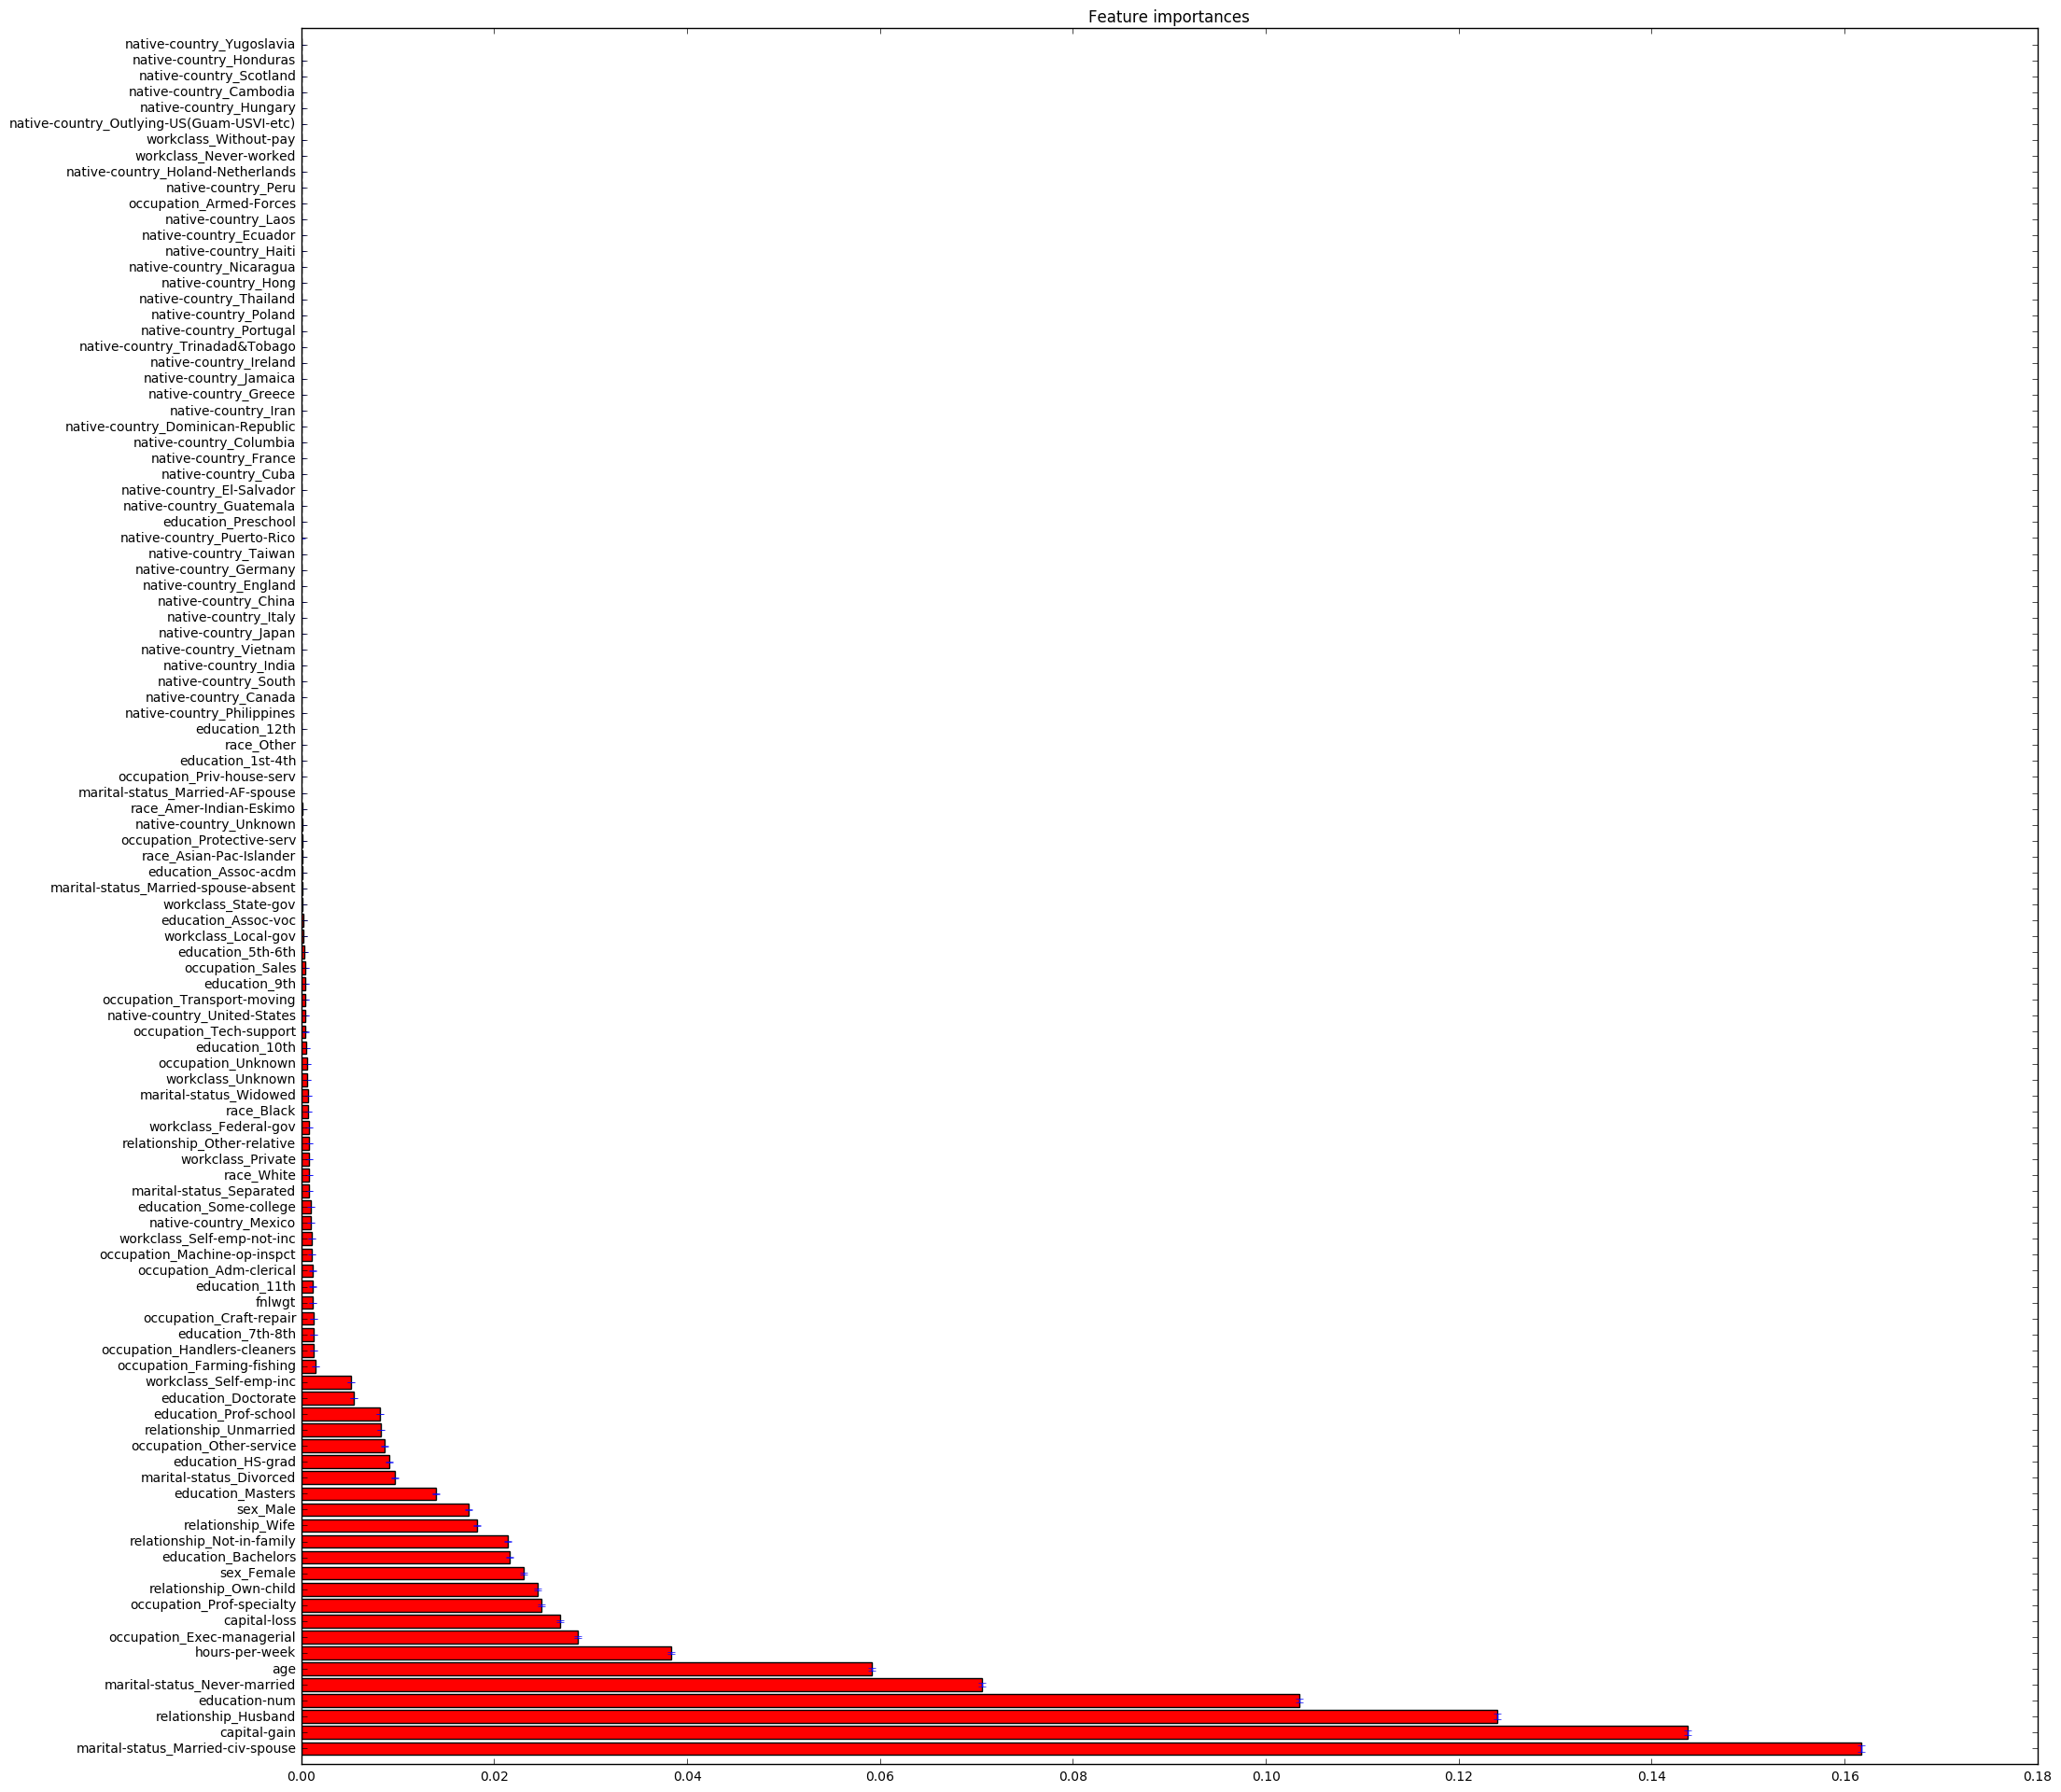

In [11]:

# Plot the feature importances of the forest
feat_important_indeces = [Xtrain.columns[indices[f]] for f in range(Xtrain.shape[1])]
_ = plt.figure(figsize=(24, 24))
_ = plt.title("Feature importances")
_ = plt.barh(range(Xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
_ = plt.yticks(range(Xtrain.shape[1]), feat_important_indeces)
_ = plt.ylim([-1, Xtrain.shape[1]])

plt.show()

Notes on model performance:

  - Recall from the group that earns above 50k/year was less than 50%, meaning the model has trouble identifying them.
  - Marital status was a big predictor of the earning range